In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 15.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
# library for stock market data (Yahoo Finance)
import yfinance as yf

# libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# libraries for timestamps
from datetime import datetime

# libraries for machine learning
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Use GPU if available, otherwise use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

Using cuda


In [ ]:
def download_data(stock, start_time, end_time):
  """
  Download stock data using Yahoo Finance
  """
  data = yf.download(stock, start_time, end_time)
  print(f"Downloaded data for {stock}")
  return data

In [ ]:
def plot_data(data):
  """
  Plot stock closing prices
  """
  plt.title("Stock Closing Prices")
  plt.plot(data['Close'])
  plt.xlabel('Time')
  plt.xticks(rotation=90)
  plt.ylabel('Closing Price')
  plt.show()

In [ ]:
# company that we will be attempting to predict
company = 'ETSY'

# gather data
now = datetime.now()
end = datetime(now.year - 1, now.month, now.day)
start = datetime(end.year - 3, end.month, end.day) # gather 3 years worth of data

# download the data
stock_data = pd.DataFrame(download_data(company, start, end))

[*********************100%***********************]  1 of 1 completed
Downloaded data for ETSY


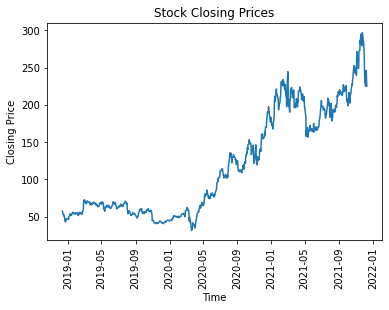

In [ ]:
# plot the stock data
plot_data(stock_data)

In [ ]:
# get the closing data
dataset = pd.DataFrame(stock_data['Close'])

# scale the date between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset.values.reshape(-1, 1))

In [ ]:
# Extract the X_train and y_train data (consisting of 90-days worth of data)
prediction_days = 90

X_train = []
y_train = []

for i in range(prediction_days, len(scaled_data)):
  X_train.append(scaled_data[i-prediction_days:i])
  y_train.append(scaled_data[i, 0])

# Convert to NumPy arrays and then to PyTorch tensors
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_train = torch.unsqueeze(y_train, axis=1)

# Put tensors onto the GPU
X_train = X_train.to(device)
y_train = y_train.to(device)

In [ ]:
# create the LSTM
class LSTM(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
    super(LSTM, self).__init__()

    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=0.2)

    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    # h0 = hidden state, c0 = cell state
    h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
    c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()

    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

    out = self.fc(out[:, -1, :])
    
    return out

In [ ]:
# instantiate the model, and define the optimizer and the criterion (loss function)
model = LSTM(1, 1, 53, 3)
model = model.to(device) 

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
# put the model into training mode
model.train()

# keep track of loss
losses = []

for i in range(500):
  # predict and calculate the loss
  y_train_pred = model(X_train).to(device)
  loss = criterion(y_train_pred, y_train)
  losses.append(loss.item())

  if i % 10 == 0 and i != 0:
    print(f"Epoch: {i}, Loss: {loss.item()}")
  
  # backward pass
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 10, Loss: 0.06696831434965134
Epoch: 20, Loss: 0.06418316811323166
Epoch: 30, Loss: 0.05410873144865036
Epoch: 40, Loss: 0.017500776797533035
Epoch: 50, Loss: 0.009057323448359966
Epoch: 60, Loss: 0.005538350902497768
Epoch: 70, Loss: 0.004481600131839514
Epoch: 80, Loss: 0.003806579392403364
Epoch: 90, Loss: 0.003738445695489645
Epoch: 100, Loss: 0.003289590124040842
Epoch: 110, Loss: 0.0030830358155071735
Epoch: 120, Loss: 0.003091561608016491
Epoch: 130, Loss: 0.003081016708165407
Epoch: 140, Loss: 0.003101210342720151
Epoch: 150, Loss: 0.0028139082714915276
Epoch: 160, Loss: 0.002748394850641489
Epoch: 170, Loss: 0.0028135054744780064
Epoch: 180, Loss: 0.0025538422632962465
Epoch: 190, Loss: 0.0025294264778494835
Epoch: 200, Loss: 0.0022809256333857775
Epoch: 210, Loss: 0.0024081890005618334
Epoch: 220, Loss: 0.0022801386658102274
Epoch: 230, Loss: 0.0022257911041378975
Epoch: 240, Loss: 0.0023918470833450556
Epoch: 250, Loss: 0.0021953261457383633
Epoch: 260, Loss: 0.002313

Text(0, 0.5, 'MSE Loss')

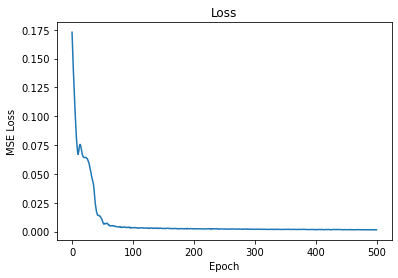

In [ ]:
# Plot the model loss
plt.title("Loss")
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

In [ ]:
# create testing data
now = datetime.now()
end = datetime(now.year, now.month, now.day)
start = datetime(end.year - 1, end.month, end.day)

test_data = pd.DataFrame(download_data(company, start, end))

[*********************100%***********************]  1 of 1 completed
Downloaded data for ETSY


In [ ]:
# get closing prices of the test data
prices = test_data['Close'].values

total_dataset = pd.concat((stock_data['Close'], test_data['Close']), axis=0)
total_dataset

Date
2018-12-12     57.430000
2018-12-13     55.049999
2018-12-14     54.340000
2018-12-17     51.169998
2018-12-18     51.849998
                 ...    
2022-12-05    137.210007
2022-12-06    135.009995
2022-12-07    130.130005
2022-12-08    134.500000
2022-12-09    126.779999
Name: Close, Length: 1007, dtype: float64

In [ ]:
# create model inputs
model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [ ]:
# Create testing dataset
X_test = []

for i in range(prediction_days, len(model_inputs)):
  X_test.append(model_inputs[i-prediction_days:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test = torch.from_numpy(X_test).type(torch.Tensor)
X_test = X_test.to(device)

In [ ]:
# put the model into evaluation mode
model.eval()

# make predictions
with torch.no_grad():
  predictions = model(X_test)

  predictions = predictions.cpu().numpy()
  predictions = scaler.inverse_transform(predictions)

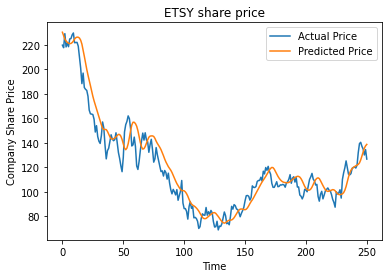

In [ ]:
# Plot the predictions and the actual price
plt.plot(prices, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title(f"{company} share price")
plt.xlabel("Time")
plt.ylabel("Company Share Price")
plt.legend()

In [ ]:
# predict the next business day's price
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs)+1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
real_data = torch.from_numpy(real_data).type(torch.Tensor)
real_data = real_data.to(device)

with torch.no_grad():
  prediction = model(real_data)
  prediction = prediction.cpu().numpy()
  prediction = scaler.inverse_transform(prediction)
  print(f"Prediction: {prediction}")

Prediction: [[138.87584]]
